In [48]:
!pip install --upgrade pymc~=5.11 numpy openpyxl graphviz arviz jax jaxlib blackjax pytensor~=2.18 scikit-learn

  Using cached pytensor-2.19.0-cp310-cp310-macosx_14_0_arm64.whl


In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from copy import deepcopy
from sklearn.preprocessing import StandardScaler


/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:113: RuntimeWarning: coroutine 'Kernel.poll_control_queue' was never awaited
  self.state = state
/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:113: RuntimeWarning: coroutine 'IPythonKernel.poll_stopped_queue' was never awaited
  self.state = state
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Попробуем предсказать инфляцию с помощью BVAR



In [21]:
# Идём по гайду:
# https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html

# Данные вот отсюда:
# https://github.com/european-central-bank/BEAR-toolbox/tree/master/tbx/replications

# BEAR
# df_full = pd.read_excel("data_economic/data_.xlsx",index_col=0)
df_full = pd.read_excel("data_economic/infl_DB_BVAR.xlsx",index_col=0)

# нормализуем данные
scalar = StandardScaler()
df_full[:] = scalar.fit_transform(df_full.values)

# проверяем, что в колонках только числовые переменные - '1974q1, ... ' - отправили в индекс
df_full

,CPI_sa,RUONIA,NEER,iMOEX,IFX_cbonds,PMI,credit_tot,retail,М2,brent,urals,unemp_sa,wages
2008m1,0.539640,-1.461499,1.700160,-0.612497,-1.327259,0.794141,-0.759930,-1.674156,-1.232742,0.521519,0.513264,0.837084,-1.348409
2008m2,0.698811,-0.972826,1.671664,-0.498504,-1.328534,1.281629,-1.468856,-1.650277,-1.225789,0.684405,0.639652,1.149107,-1.317181
2008m3,0.854970,-0.939139,1.693606,-0.540863,-1.331157,0.596458,-1.314181,-1.550170,-1.211678,1.019021,0.950321,0.722452,-1.272583
2008m4,1.352187,-1.024535,1.716567,-0.489328,-1.318505,1.355001,-1.059431,-1.517802,-1.213012,1.190043,1.155254,0.299187,-1.249070
2008m5,1.240237,-1.136964,1.700747,-0.147853,-1.305648,1.250263,-1.088694,-1.471936,-1.196292,1.757609,1.682439,-0.120728,-1.242370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023m11,0.297364,2.202469,-1.292443,1.494776,1.874061,0.285724,1.340687,2.152315,2.399887,0.133759,0.073914,-1.919925,1.870684
2023m12,-0.105098,2.303262,-1.321092,1.406484,1.887581,-0.063171,2.596561,3.033172,2.664878,-0.059668,-0.135644,-1.996594,3.543512
2024m1,-0.152873,2.472474,-1.263953,1.558863,1.947094,0.305107,0.471490,1.855794,2.639067,0.018543,-0.065539,-1.996594,3.543512
2024m2,-0.148112,2.512743,-1.264007,1.615284,1.975476,0.305107,0.915883,1.855794,2.711917,0.119020,0.047406,-1.996594,3.543512


Sampling: [obs, vals_raw]


INFERENCE PARAMS
inference type: posterior
Count equations: 4
Count lags: 2


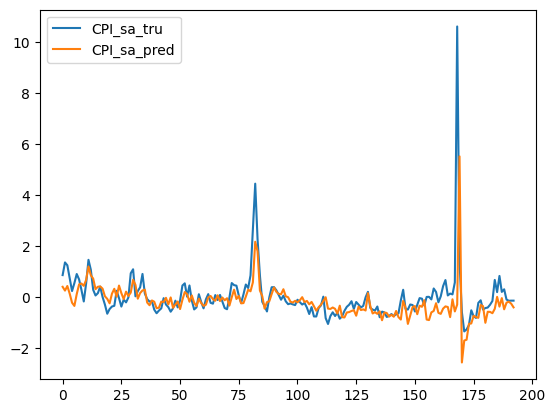

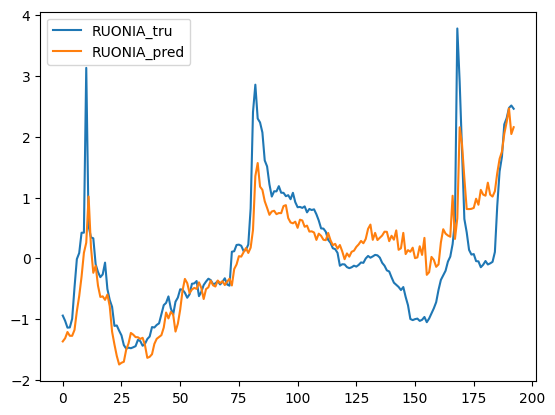

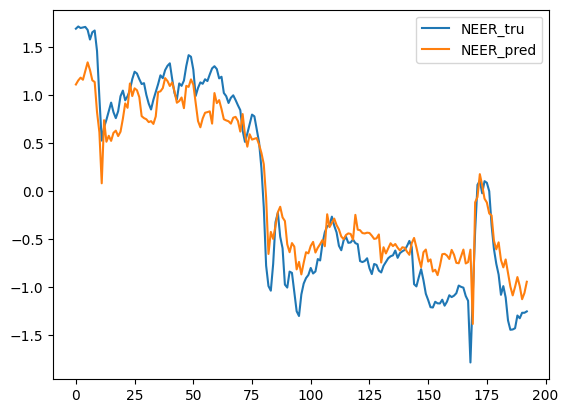

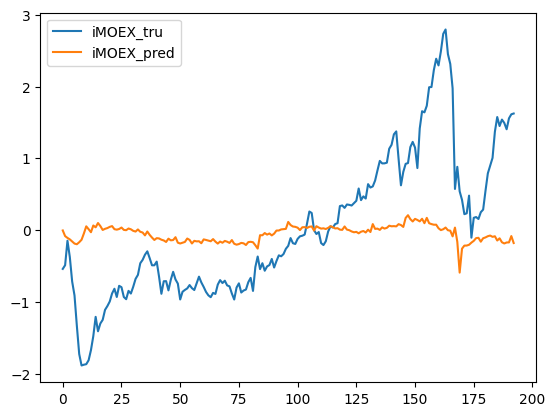

In [33]:
from src import bvar_pymc
from src import ols_linear
from importlib import reload

reload(bvar_pymc)
reload(ols_linear)

create_bvar_model = bvar_pymc.create_bvar_model
predict_bvar_model = bvar_pymc.predict_bvar_model
estimate_ols_coefs = ols_linear.estimate_ols_coefs
predict_bvar_forward_step = bvar_pymc.predict_bvar_forward_step



In [25]:
# оцениваем prior параметры через линейные регрессии
n_eq = 4
n_lags = 2
n_train = 120
ols_alpha, ols_lag_coefs = estimate_ols_coefs(df_full, 
                                              n_train=n_train,                                              
                                              n_eq=n_eq, 
                                              n_lags=n_lags)


[118  13]
[118  13]
ar_eq: [118]
ar_eq: [118]
ar_eq: [118]
ar_eq: [118]
betax: [118   4]
mean: [118   4]
obs [118   4]
  lag_coefs: shape=(4, 2, 13)
      alpha: shape=(1, 4)
noise_chol_cholesky-cov-packed__: shape=(10,)
 noise_chol: shape=(10,)
   vals_raw: shape=(118, 4)


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/bvar_macro310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Total train duration: 261.5s


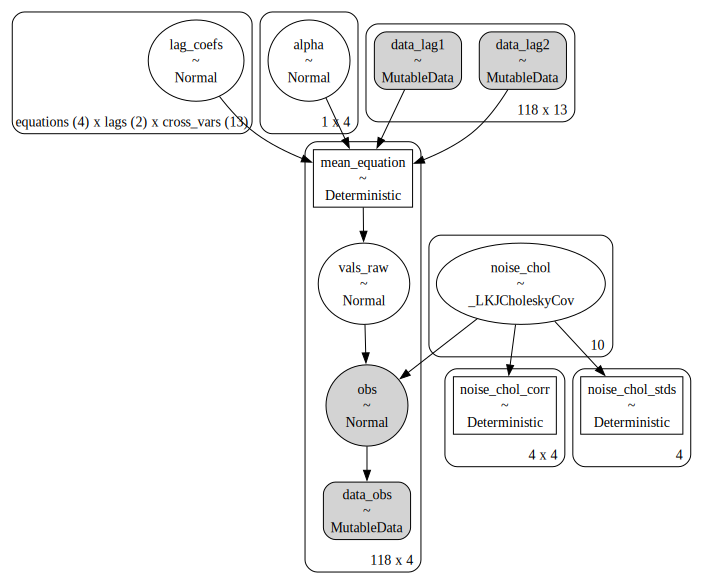

In [26]:
priors = {
    "lag_coefs": {"mu": ols_lag_coefs, "sigma": 1.0},
    "alpha": {"mu": ols_alpha, "sigma": 5.0},
    "noise_chol": {"eta": 1.0, "sigma": 1.0},
    "noise": {"sigma": 1.0},

}


# тут нужно ставить в расчёте хотя бы 100-150 сэмплов на один параметр.
# Например,
# 13 переменных х 2 лага х 4 уравнения х 150 +  4 константы в каждом уравнении  ~= 16 200 сэмплов
# (n_eq * (n_eq-1) /2 + n_eq) = 10 параметров в матрице Холецки ~= + 1 000 сэмплов

sampler_params = {'chains': 4, # должно равняться количству ядер на компьютере
                  'draws': 5000, 
                  'tune': 5000, 
                  'nuts_sampler': 'blackjax', 
                  # 'nuts_sampler_kwargs':{'chain_method': 'vectorized'} # для blackjax
                 }


n_lags = 2 # number of lags
n_train = 120 # number of observations to user for training, you can use negative value to train on full dataset
mv_norm = True # Use multivariate normal distribution

model, idata = create_bvar_model(df_full, 
                               n_eq = 4,
                               n_train = n_train, 
                               n_lags = n_lags, 
                               mv_norm = True,
                               priors = priors, 
                               sampler_params = sampler_params) 

pm.model_to_graphviz(model)

In [27]:
# Здесь наша оценка коэффициентов модели
# noise_chol_corr - только в случае эстимации ковариации через Холецки
az.summary(idata, var_names=["alpha", "lag_coefs", "noise_chol_corr"])

/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/bvar_macro310/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.349,0.536,-1.050,0.351,0.264,0.205,4.0,13.0,4.13
"alpha[0, 1]",-0.101,0.600,-1.144,0.506,0.288,0.219,5.0,11.0,2.91
"alpha[0, 2]",-0.254,0.369,-0.816,0.199,0.182,0.141,5.0,14.0,3.08
"alpha[0, 3]",-0.375,0.477,-0.880,0.276,0.226,0.174,5.0,16.0,2.61
"lag_coefs[CPI_sa, 1, var_CPI_sa]",1.204,0.427,0.491,1.574,0.205,0.156,6.0,18.0,2.79
...,...,...,...,...,...,...,...,...,...
"noise_chol_corr[2, 3]",0.026,0.501,-0.784,0.546,0.250,0.192,4.0,11.0,3.76
"noise_chol_corr[3, 0]",0.049,0.257,-0.297,0.321,0.129,0.098,4.0,11.0,4.35
"noise_chol_corr[3, 1]",-0.099,0.532,-0.695,0.774,0.266,0.204,4.0,11.0,4.14
"noise_chol_corr[3, 2]",0.026,0.501,-0.784,0.546,0.250,0.192,4.0,11.0,3.76


Sampling: [alpha, lag_coefs, noise_chol, obs, vals_raw]


inference data
Count equations: 4
Count lags: 2


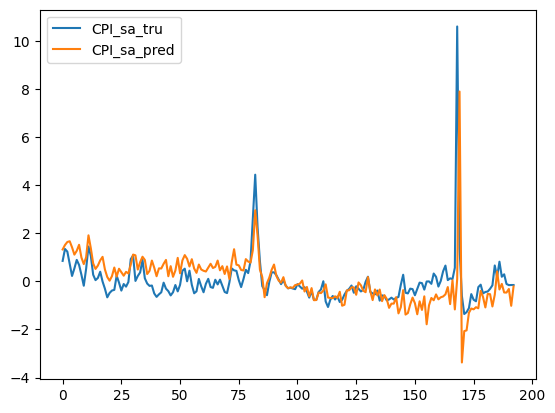

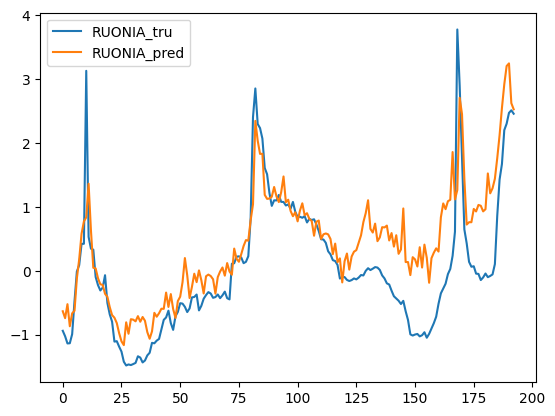

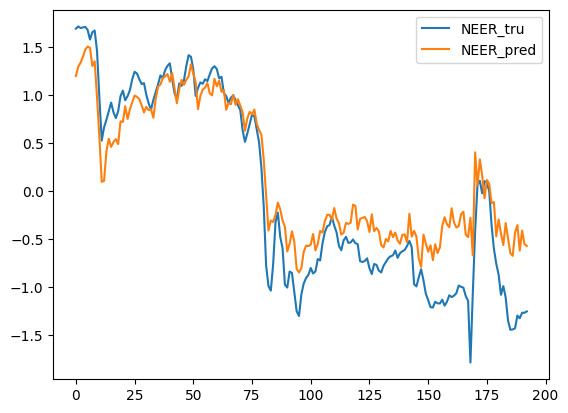

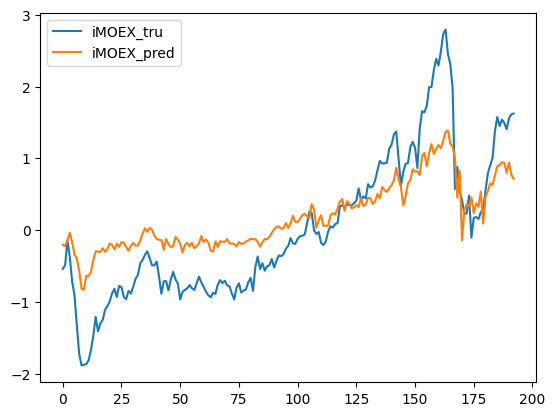

In [28]:
# какой был предикт до уточнения параметров через баес
predict_bvar_model(df_full, model, idata=None, inference_type='prior')

Sampling: [obs, vals_raw]


inference data
Count equations: 4
Count lags: 2


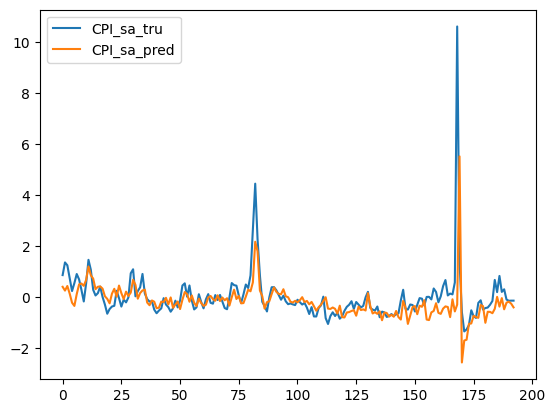

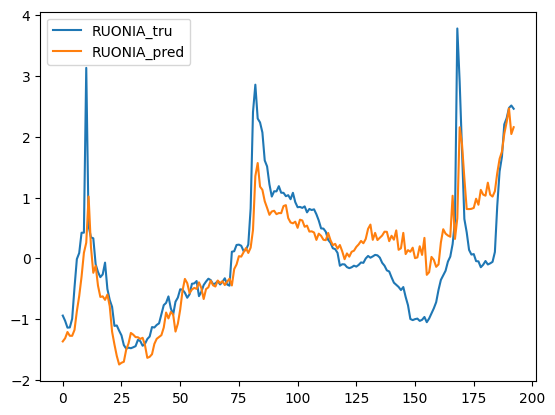

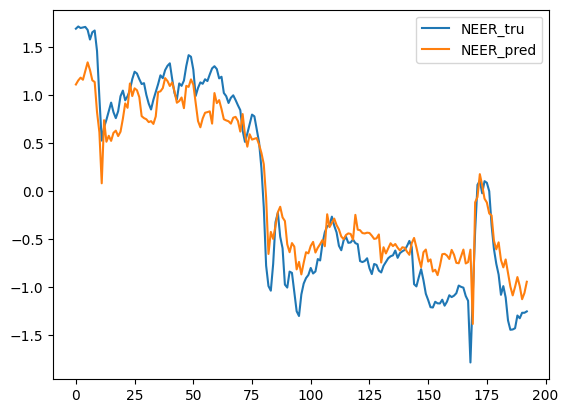

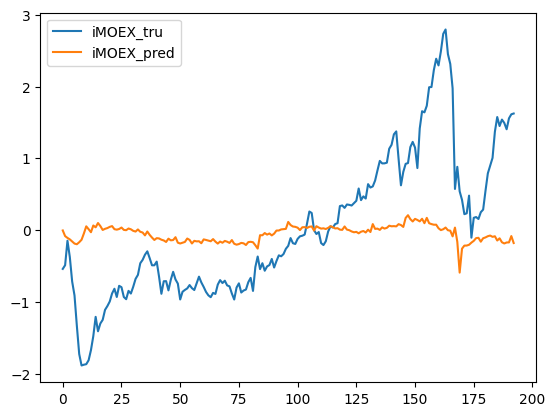

In [29]:
# Теперь предикт после баес
df_preds = predict_bvar_model(df_full, model, idata=idata)

## Часть 2

In [37]:
# сделаем фит на всех данных, а потом предскажем одну точку вперёд
model, idata = create_bvar_model(df_full, 
                               n_train = -1, 
                               n_eq = 4,
                               n_lags = n_lags, 
                               priors = priors, 
                               sampler_params = sampler_params, 
                               mv_norm = mv_norm) 

print ("Model fit done")

[193  13]
[193  13]
ar_eq: [193]
ar_eq: [193]
ar_eq: [193]
ar_eq: [193]
betax: [193   4]
mean: [193   4]
obs [193   4]
  lag_coefs: shape=(4, 2, 13)
      alpha: shape=(1, 4)
noise_chol_cholesky-cov-packed__: shape=(10,)
 noise_chol: shape=(10,)
   vals_raw: shape=(193, 4)


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/bvar_macro310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Total train duration: 355.7s
Model fit done


Sampling: [obs]


INFERENCE PARAMS
inference type: posterior
Count equations: 4
Count lags: 2


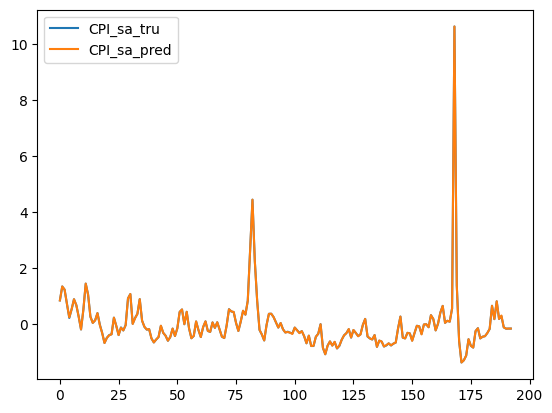

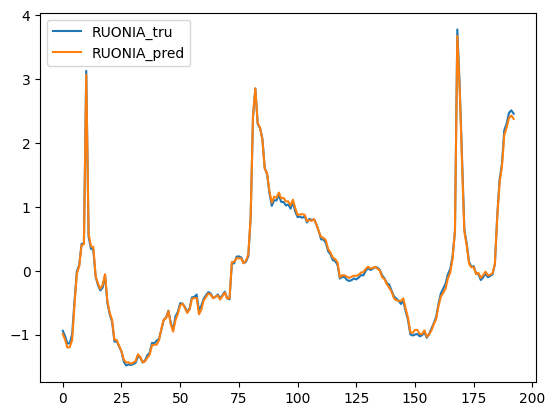

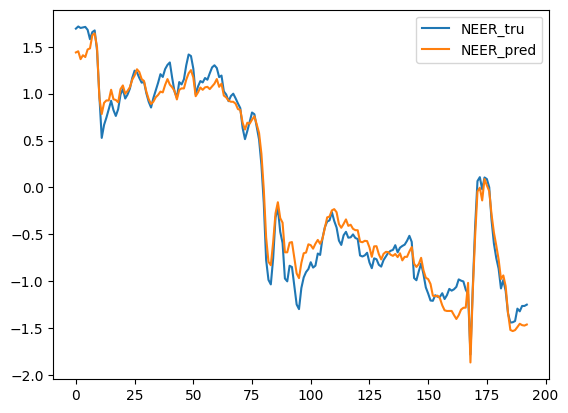

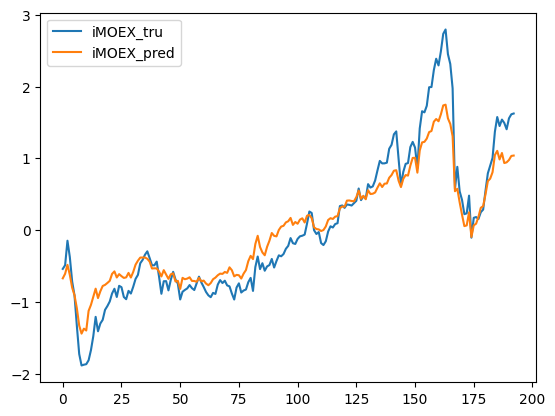

In [38]:
from src import bvar_pymc
from src import ols_linear
from importlib import reload

reload(bvar_pymc)
reload(ols_linear)

create_bvar_model = bvar_pymc.create_bvar_model
predict_bvar_model = bvar_pymc.predict_bvar_model
estimate_ols_coefs = ols_linear.estimate_ols_coefs

df_preds = predict_bvar_model(df_full, model, idata=idata)

In [45]:
# Теперь запредиктим одно новую точку, используя самые послдение данные
# вот эту штуку нужно обернуть в цикл, чтобы предсказать по одному наблюдению вперёд

df_preds = predict_bvar_forward_step(df_full, model, idata=idata)
df_preds


Sampling: [obs, vals_raw]


INFERENCE PARAMS
inference type: one_step_forward_forecast
Count equations: 4
Count lags: 2


,CPI_sa,RUONIA,NEER,iMOEX
forecast,0.843593,1.019905,-1.568899,0.770982
